In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.metrics import mean_squared_error
import warnings
sns.set()
warnings.filterwarnings("ignore")

In [13]:
def ArmaGarch(data):
    # 1 pandas
    data_backup = data.copy()
    data_backup.Date = pd.to_datetime(data_backup.Date)
    data_backup.set_index("Date", inplace = True)
    
    data = data_backup[["BTC_price_ret", "BTC_price_vol"]]
    
    # 2 split
    train_df = data.loc[:"2022-07-31"]
    test_df = data.loc["2022-08-01":]
    
    # print(adfuller(train_df["BTC_price_ret"][1:]))
    # print(adfuller(train_df["BTC_price_vol"][1:]))
    
    # 3 ACF & PACF
    plt.rcParams["figure.figsize"] = 18, 5
    fig, axes = plt.subplots(1, 2)
    sgt.plot_acf(train_df.BTC_price_ret[1:], zero = False, lags = 40, ax = axes[0])
    sgt.plot_pacf(train_df.BTC_price_ret[1:], zero = False, lags = 40, ax = axes[1])
    axes[0].set_title("ACF For Returns", size = 24)
    axes[1].set_title("PACF For Returns", size = 24)
    plt.show()
    
    # 4 ARMA
    model = SARIMAX(train_df["BTC_price_ret"][1:], order = (2, 0, 2))
    model_results = model.fit()
    print(model_results.summary())
    
    arma_forecast = model_results.get_forecast(len(test_df.index))
    arma_predictions_df = arma_forecast.conf_int(alpha = 0.05) # Confidence level of 95%
    arma_predictions_df["Predictions"] = model_results.predict(start = test_df.index[0], end = test_df.index[-1])
    
    # MSE 
    arma_mse = mean_squared_error(test_df["BTC_price_ret"].values, arma_predictions_df["Predictions"])
    
    # plot prediction
    plt.rcParams["figure.figsize"] = 18, 5
    plt.plot(test_df["BTC_price_ret"], color = "blue", label = "Actual Values")
    plt.plot(arma_predictions_df["Predictions"], color = "red", label = "Predictions")
    plt.plot(arma_predictions_df["upper BTC_price_ret"], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
    plt.plot(arma_predictions_df["lower BTC_price_ret"], color = "green", linestyle = "--")
    plt.title(f"Predictions(95% confidence) vs Actuals for ARMA(2, 2) Model (MSE - {round(arma_mse, 2)})", size = 24)
    plt.legend()
    plt.show()
    
    # plot residual
    plt.rcParams["figure.figsize"] = 18, 5
    plt.plot(model_results.resid)
    plt.title("Residuals of ARMA(2, 2) Model", size = 24)
    plt.show()
    
    # plot PACF
    plt.rcParams["figure.figsize"] = 18, 5
    sgt.plot_pacf(model_results.resid[1:], zero = False, lags = 40)
    plt.show()
    
    # 5 GARCH
    # data preprocess
    resid_df = data.copy()
    resid_df["BTC_ret_resid"] = resid_df["BTC_price_ret"].shift(1).loc[resid_df.index]
    resid_df.loc[train_df.index[1]:train_df.index[-1], "BTC_ret_resid"] = model_results.resid
    
    # build GARCH model
    resid_model = arch_model(resid_df["BTC_ret_resid"][1:], p = 2, q = 1, vol = "GARCH")
    resid_model_results = resid_model.fit(last_obs = test_df.index[0], update_freq = 5)
    print(resid_model_results.summary())
    print(resid_model.distribution.ppf([0.01, 0.05]))
    
    # 6 ARMA +- GARCH
    # combine forecasting result
    resid_forecasts = resid_model_results.forecast().residual_variance.loc[test_df.index].values
    
    arma_garch_predictions_df = arma_predictions_df.copy()
    arma_garch_predictions_df["lower BTC_price_ret"] = arma_garch_predictions_df["Predictions"] - resid_forecasts.reshape(-1,)
    arma_garch_predictions_df["upper BTC_price_ret"] = arma_garch_predictions_df["Predictions"] + resid_forecasts.reshape(-1,)
    
    # plot combined result
    plt.rcParams["figure.figsize"] = 18, 5
    plt.plot(test_df["BTC_price_ret"], color = "blue", label = "Actual Values")
    plt.plot(arma_garch_predictions_df["Predictions"][test_df.index], color = "red", label = "Predictions")
    plt.plot(arma_garch_predictions_df["lower BTC_price_ret"][test_df.index], color = "green", linestyle = "--", label = "Confidence Intervals")
    plt.plot(arma_garch_predictions_df["upper BTC_price_ret"][test_df.index], color = "green", linestyle = "--")
    plt.legend()
    plt.plot()
    
    return arma_garch_predictions_df

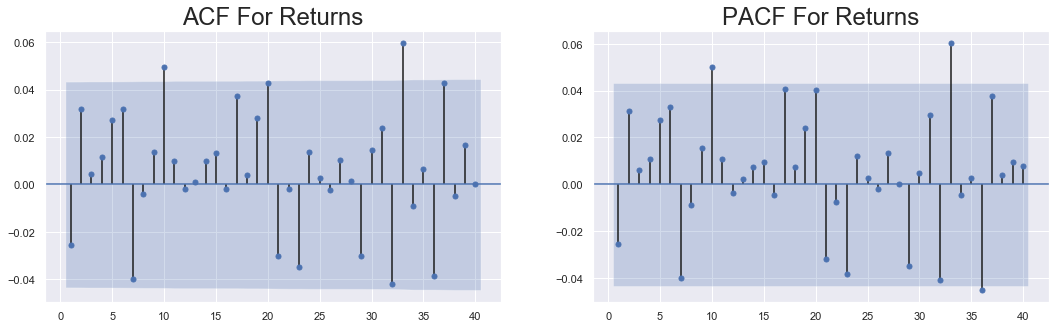

                               SARIMAX Results                                
Dep. Variable:          BTC_price_ret   No. Observations:                 2037
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -5784.298
Date:                Fri, 18 Nov 2022   AIC                          11578.595
Time:                        04:48:53   BIC                          11606.691
Sample:                    01-02-2017   HQIC                         11588.902
                         - 07-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4383      0.324      1.352      0.176      -0.197       1.074
ar.L2          0.5463      0.323      1.689      0.091      -0.088       1.180
ma.L1         -0.4634      0.331     -1.402      0.1

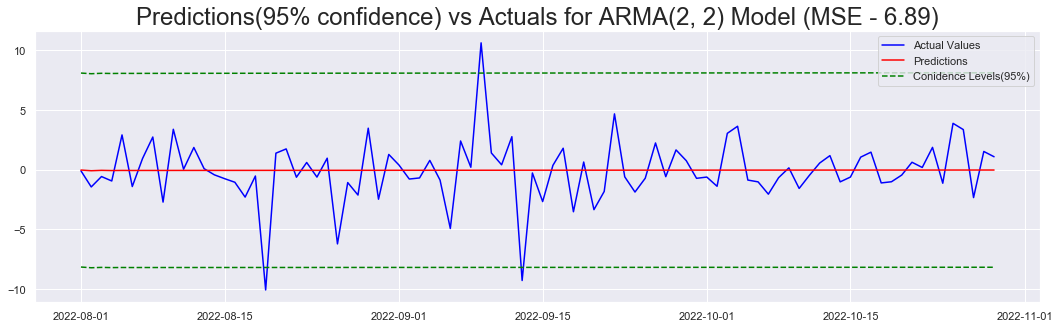

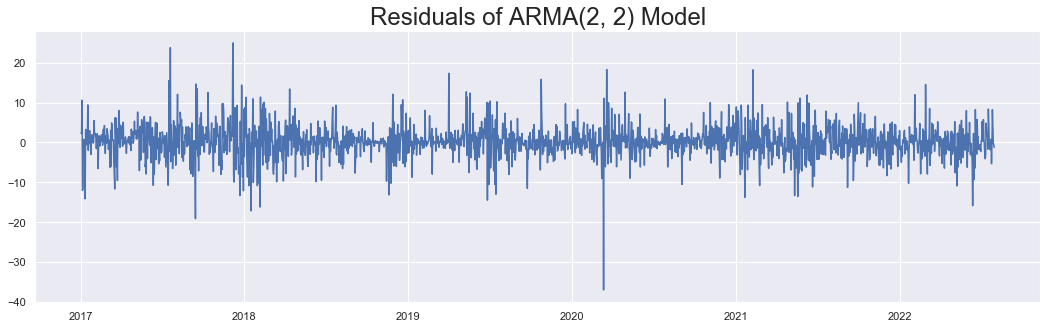

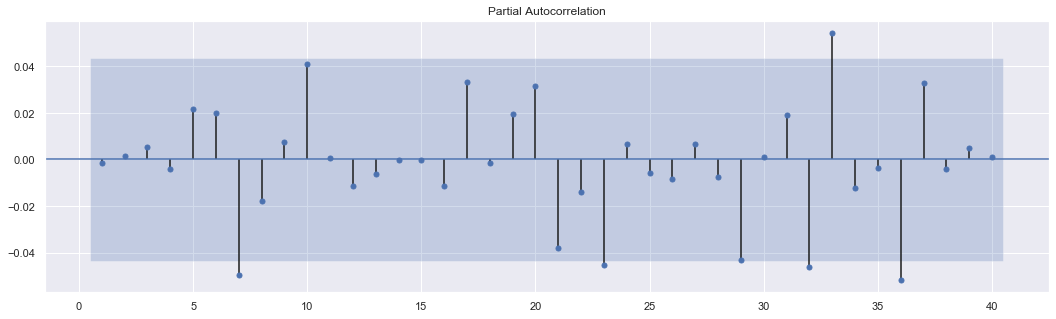

Iteration:      5,   Func. Count:     39,   Neg. LLF: 5678.6804367030145
Iteration:     10,   Func. Count:     73,   Neg. LLF: 5676.09675781875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5675.865082666919
            Iterations: 14
            Function evaluations: 97
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          BTC_ret_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5675.87
Distribution:                  Normal   AIC:                           11361.7
Method:            Maximum Likelihood   BIC:                           11389.8
                                        No. Observations:                 2037
Date:                Fri, Nov 18 2022   Df Residuals:                     2036
Time:          

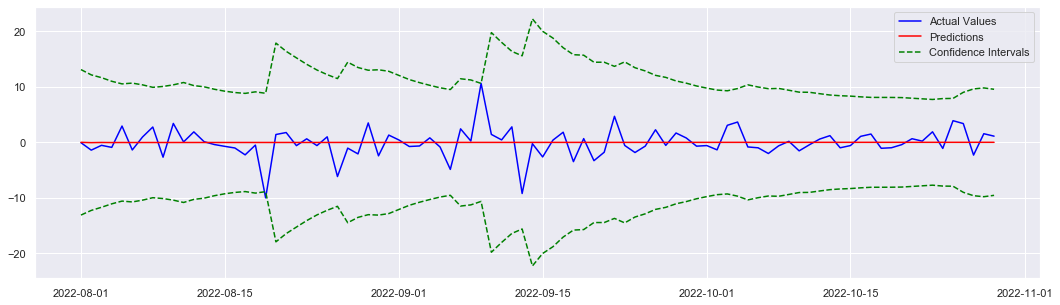

In [14]:
data = pd.read_csv("BTC_data.csv")
result = ArmaGarch(data)